# EE 467 Lab 2: Breaking CAPTCHAs with PyTorch

This is a PyTorch implementation of Lab 2, converted from the original TensorFlow/Keras version.

In this lab, we break CAPTCHAs using a Convolutional Neural Network (CNN) implemented in PyTorch.

## Prerequisites

Upload these files to Colab:
- `lab_2_helpers.py`
- `captcha-images.tar.xz`

In [1]:
%pip install matplotlib scikit-learn "opencv-python>4" imutils
%pip install torch torchvision

In [2]:
from google.colab import files
uploaded = files.upload()

Saving lab_2_helpers.py to lab_2_helpers.py


In [3]:
from google.colab import files
uploaded = files.upload()

Saving captcha-images.tar.xz to captcha-images.tar.xz


In [4]:
!tar -xJf captcha-images.tar.xz
!ls

captcha-images	captcha-images.tar.xz  lab_2_helpers.py  sample_data


In [5]:
import sys
sys.path.insert(0, '/content')

import os, pickle, glob, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from lab_2_helpers import *

# Preprocessing
## Ground Truth Characters Extraction

In [6]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
pprint(captcha_image_paths[:10])

['./captcha-images/G4US.png',
 './captcha-images/8AEZ.png',
 './captcha-images/4MXT.png',
 './captcha-images/2N2V.png',
 './captcha-images/L5XP.png',
 './captcha-images/3G9T.png',
 './captcha-images/8BFG.png',
 './captcha-images/2QTQ.png',
 './captcha-images/N3V7.png',
 './captcha-images/5VBJ.png']


In [7]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
pprint(captcha_texts[:10])

['G4US', '8AEZ', '4MXT', '2N2V', 'L5XP', '3G9T', '8BFG', '2QTQ', 'N3V7', '5VBJ']


## Loading and Transforming Images

Figure(2000x500)


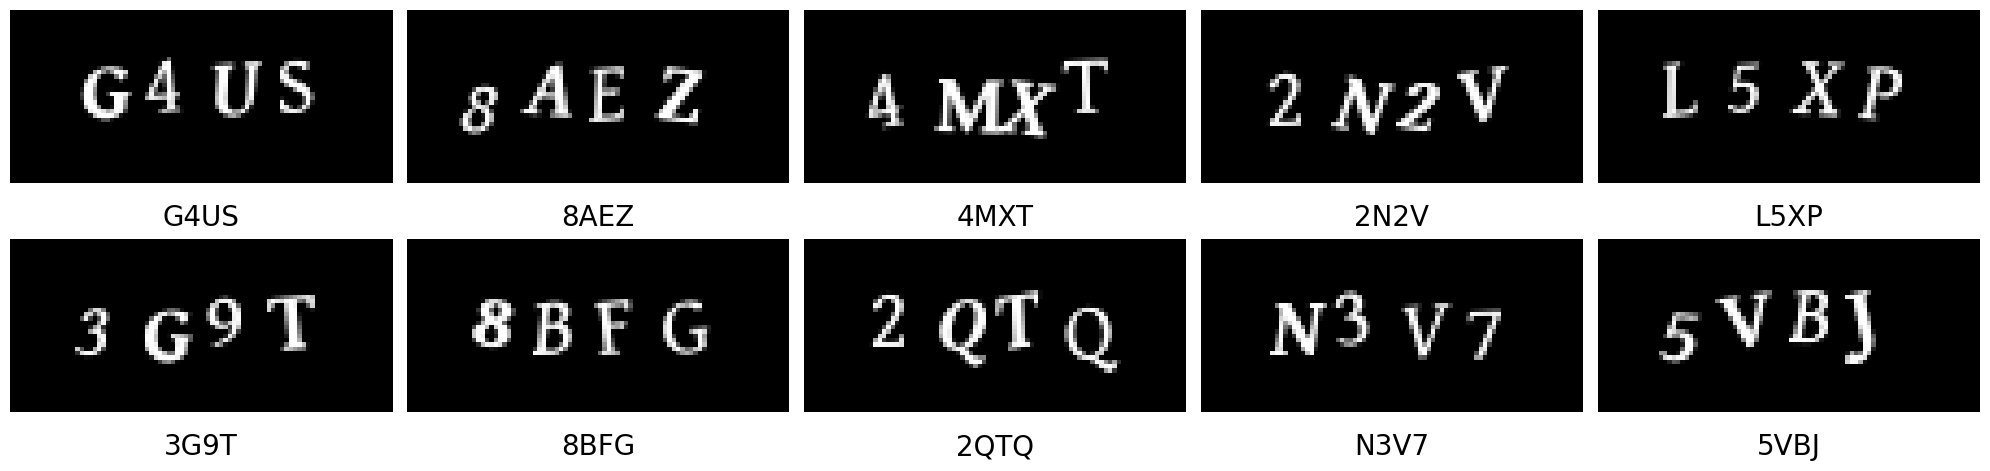

In [8]:
def load_transform_image(image_path):
    """ Load and transform image into grayscale. """
    # Load image with OpenCV
    image = cv2.imread(image_path)
    # Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Add extra padding (8px) around the image
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
print_images(captcha_images[:10], n_rows=2, texts=captcha_texts[:10])

In [9]:
# Train-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Bounding Box Extraction

In [10]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """
    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            char_regions.append((x, y, w, h))

    if len(char_regions)!=4:
        return None
    char_regions.sort(key=lambda x: x[0])

    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)

    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)
        char_counts[char] = char_count+1

FORCE_EXTRACT_CHAR = False
char_counts = {}

if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        char_images = extract_chars(captcha_image)
        if char_images is None:
            continue
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

## Label Encoding

In [11]:
# Path of occurred characters (labels)
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    """ Process character image and turn it into feature. """
    image_resized = resize_to_fit(image, 20, 20)
    feature = image_resized[..., None]
    return feature

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    label = image_path.split(os.path.sep)[-2]
    return feature, label

# Make features and labels from character image paths
features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Scale raw pixel values into range [0, 1]
features_tv = np.array(features_tv, dtype="float")/255
# Convert labels into one-hot encodings
lb = LabelBinarizer()
labels_one_hot_tv = lb.fit_transform(labels_tv)
n_classes = len(lb.classes_)

# Further split the training data into training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
)

# Save mapping from labels to one-hot encoding
with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_vali)}")
print(f"Number of classes: {n_classes}")

Training samples: 2679
Validation samples: 893
Number of classes: 32


# PyTorch Dataset and DataLoader

In PyTorch, we need to create a Dataset class and use DataLoader for batching.

In [12]:
class CaptchaDataset(Dataset):
    """ PyTorch Dataset for CAPTCHA character images """

    def __init__(self, features, labels):
        # Convert numpy arrays to PyTorch tensors
        # PyTorch expects channel-first format: (N, C, H, W)
        # Our data is (N, H, W, C), so we need to transpose
        self.features = torch.FloatTensor(features).permute(0, 3, 1, 2)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = CaptchaDataset(X_train, y_train)
vali_dataset = CaptchaDataset(X_vali, y_vali)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(vali_loader)}")

Training batches: 84
Validation batches: 28


# CNN Model Definition (PyTorch)

This is the PyTorch equivalent of the TensorFlow/Keras model:

- Conv2D Block 1: 20 filters, 5×5 kernel → MaxPooling2D (2×2)
- Conv2D Block 2: 50 filters, 5×5 kernel → MaxPooling2D (2×2)
- Flatten
- Dense: 500 units with ReLU
- Output: n_classes with Softmax

In [18]:
class CaptchaCNN(nn.Module):
    """ PyTorch CNN for CAPTCHA character recognition """

    def __init__(self, num_classes):
        super(CaptchaCNN, self).__init__()

        # First convolution block
        # Input: (1, 20, 20) -> Output: (20, 20, 20) -> After pooling: (20, 10, 10)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20,
                               kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution block
        # Input: (20, 10, 10) -> Output: (50, 10, 10) -> After pooling: (50, 5, 5)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
                               kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Flattened size: 50 * 5 * 5 = 1250
        self.fc1 = nn.Linear(50 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Second conv block
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Flatten
        x = x.reshape(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # Softmax is included in CrossEntropyLoss in PyTorch
        # So we return logits here
        return x

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CaptchaCNN(num_classes=n_classes).to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Using device: cpu
CaptchaCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=32, bias=True)
)

Total parameters: 667,102


# Training

In [19]:
# Training hyperparameters
N_EPOCHS = 10
LEARNING_RATE = 0.001

# Loss and optimizer
# Note: PyTorch's CrossEntropyLoss includes softmax, so we use logits
# We need to convert one-hot labels back to class indices
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Model checkpoint path
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pth"
FORCE_TRAINING = True

def train_epoch(model, train_loader, criterion, optimizer, device):
    """ Train for one epoch """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features = features.to(device)
        # Convert one-hot to class indices
        labels = torch.argmax(labels, dim=1).to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, vali_loader, criterion, device):
    """ Validate the model """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in vali_loader:
            features = features.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(vali_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [20]:
if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    print("Training the model...\n")

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        vali_loss, vali_acc = validate(model, vali_loader, criterion, device)

        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Vali Loss: {vali_loss:.4f}, Vali Acc: {vali_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    print(f"\nModel saved to {MODEL_WEIGHTS_PATH}")
else:
    # Load model
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))
    print(f"Model loaded from {MODEL_WEIGHTS_PATH}")

Training the model...

Epoch [1/10]
  Train Loss: 2.2889, Train Acc: 0.3624
  Vali Loss: 0.6407, Vali Acc: 0.8611
Epoch [2/10]
  Train Loss: 0.2849, Train Acc: 0.9306
  Vali Loss: 0.2609, Vali Acc: 0.9518
Epoch [3/10]
  Train Loss: 0.1029, Train Acc: 0.9791
  Vali Loss: 0.1880, Vali Acc: 0.9742
Epoch [4/10]
  Train Loss: 0.0429, Train Acc: 0.9925
  Vali Loss: 0.1453, Vali Acc: 0.9787
Epoch [5/10]
  Train Loss: 0.0256, Train Acc: 0.9944
  Vali Loss: 0.1521, Vali Acc: 0.9742
Epoch [6/10]
  Train Loss: 0.0160, Train Acc: 0.9970
  Vali Loss: 0.1288, Vali Acc: 0.9821
Epoch [7/10]
  Train Loss: 0.0189, Train Acc: 0.9970
  Vali Loss: 0.1317, Vali Acc: 0.9765
Epoch [8/10]
  Train Loss: 0.0039, Train Acc: 0.9996
  Vali Loss: 0.1297, Vali Acc: 0.9798
Epoch [9/10]
  Train Loss: 0.0010, Train Acc: 1.0000
  Vali Loss: 0.1325, Vali Acc: 0.9821
Epoch [10/10]
  Train Loss: 0.0008, Train Acc: 1.0000
  Vali Loss: 0.1390, Vali Acc: 0.9821

Model saved to ./captcha-model-pytorch.pth


# Evaluation

In [21]:
# Load labels from file
with open(LABELS_PATH, "rb") as f:
    lb = pickle.load(f)

# Dummy character images
DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1))

# Indices of CAPTCHAs on which extractions failed
extract_failed_indices = []
# Extracted character images
char_images_test = []

# Extract character images
for i, captcha_image in enumerate(captcha_images_test):
    char_images = extract_chars(captcha_image)

    if char_images:
        char_images_test.extend(char_images)
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

# Make features for character images
features_test = [make_feature(char_image) for char_image in char_images_test]
features_test = np.array(features_test, dtype="float")/255

# Convert to PyTorch tensor (channel-first format)
features_test_tensor = torch.FloatTensor(features_test).permute(0, 3, 1, 2).to(device)

# Predict with PyTorch model
model.eval()
with torch.no_grad():
    outputs = model(features_test_tensor)
    # Apply softmax to get probabilities
    probs = F.softmax(outputs, dim=1)
    # Get predictions
    _, predicted_indices = torch.max(probs, 1)
    predicted_indices = predicted_indices.cpu().numpy()

# Convert indices back to characters
preds_test = lb.classes_[predicted_indices]

# Group all 4 characters for the same CAPTCHA
preds_test = ["".join(chars) for chars in group_every(preds_test, 4)]

# Update result for CAPTCHAs on which extractions failed
for i in extract_failed_indices:
    preds_test[i] = "-"

print(f"Predictions complete. Total CAPTCHAs: {len(preds_test)}")

Predictions complete. Total CAPTCHAs: 228


# of test CAPTCHAs: 228
# correctly recognized: 214
Accuracy: 0.9385964912280702 

Figure(2000x500)
Figure(2000x600)


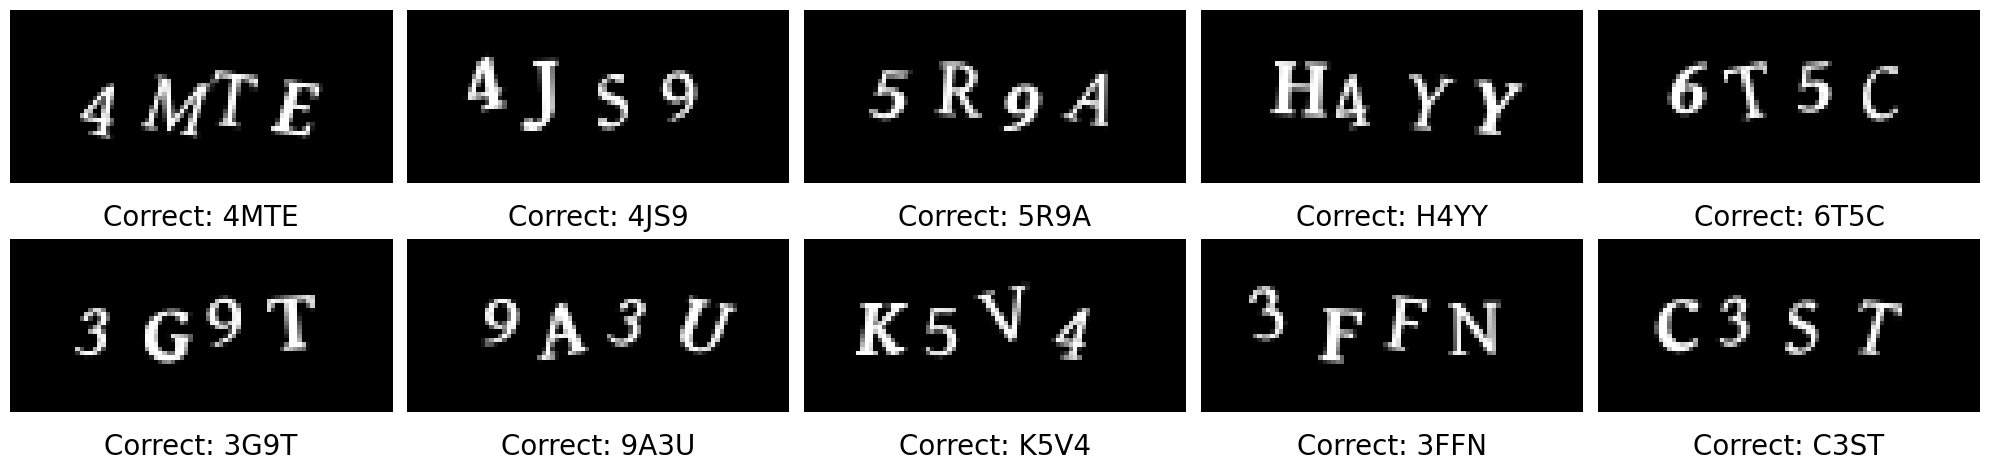

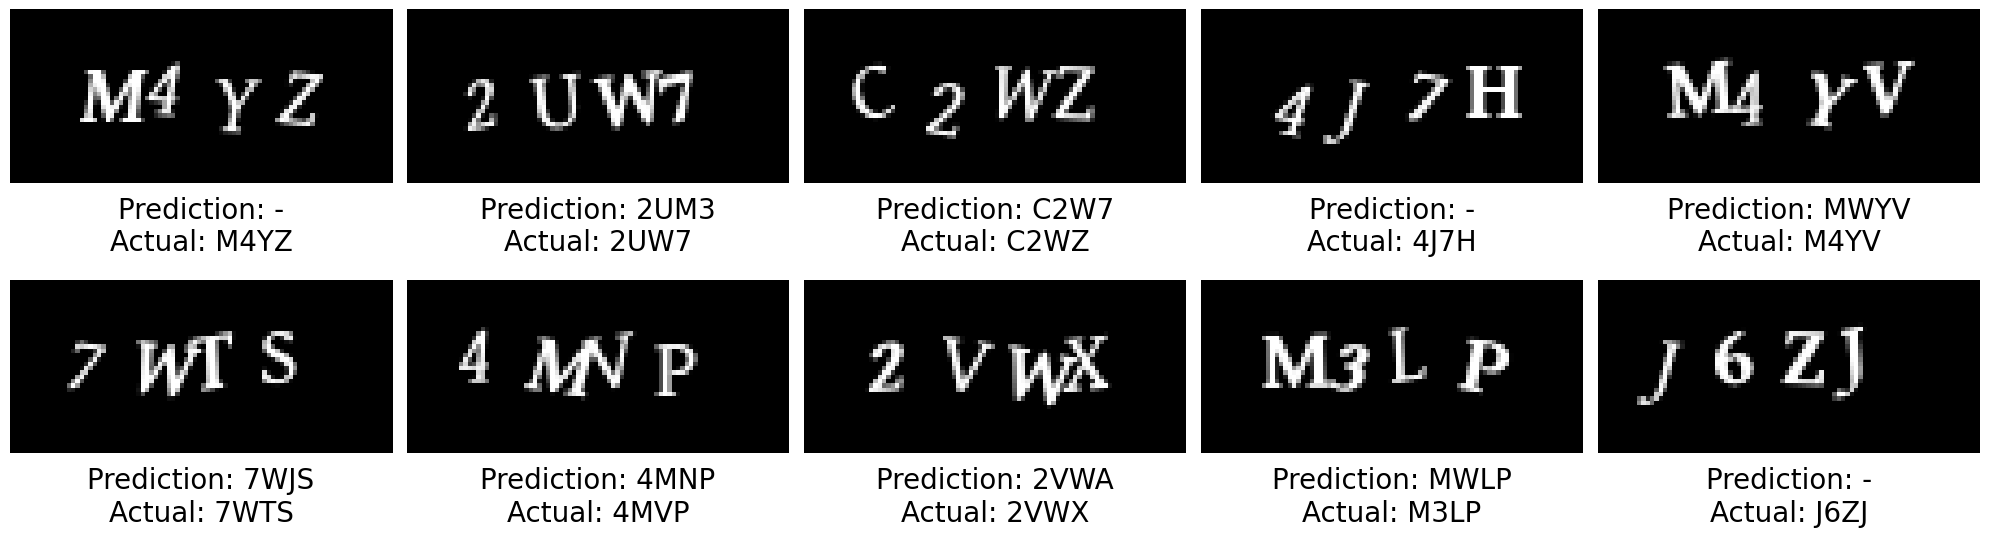

In [22]:
# Number of CAPTCHAs to display
N_DISPLAY_SAMPLES = 10

# Number of test CAPTCHAs
n_test = len(captcha_texts_test)
# Number of correct predictions
n_correct = 0

# Indices of correct predictions
correct_indices = []
# Indices of incorrect predictions
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text==actual_text:
        n_correct += 1
        if len(correct_indices)<N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices)<N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

# Show number of total / correct predictions and accuracy
print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct/n_test, "\n")

# Show all correct predictions
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

# Show all incorrect predictions
print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[
        f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" \
        for i in incorrect_indices
    ],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)

# PyTorch vs TensorFlow Comparison

## Key Differences:

### 1. **Model Definition**
- **TensorFlow/Keras**: Sequential API with `model.add()`
- **PyTorch**: Class-based with `nn.Module` and `forward()` method

### 2. **Data Format**
- **TensorFlow**: Channel-last (N, H, W, C)
- **PyTorch**: Channel-first (N, C, H, W)

### 3. **Training Loop**
- **TensorFlow/Keras**: Built-in `model.fit()`
- **PyTorch**: Manual training loop with explicit forward/backward passes

### 4. **Loss Function**
- **TensorFlow/Keras**: `categorical_crossentropy` expects one-hot labels
- **PyTorch**: `CrossEntropyLoss` expects class indices and includes softmax

### 5. **Predictions**
- **TensorFlow/Keras**: `model.predict()` returns probabilities
- **PyTorch**: Manual forward pass with `torch.no_grad()` for inference

## Expected Results:

Both implementations should achieve **similar accuracy** (~95-99%), with minor differences due to:
- Random initialization
- Different default optimizers settings
- Implementation details in convolution/pooling operations

## References

1. PyTorch Documentation: https://pytorch.org/docs/stable/index.html
2. PyTorch Tutorials: https://pytorch.org/tutorials/
3. Original TensorFlow Lab: EE 467 Lab 2
4. How to break a CAPTCHA system in 15 minutes with Machine Learning: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710